In [4]:
import os
import numpy as np
import reading 
from feature_extractor import feature_extractor
import pandas as pd
import matplotlib.pyplot as plt

Load dei Path, Con il sort giusto per far corrispondere i soggetti

In [5]:
paths_FA= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_FA_image")
paths_masks=reading.data_path("Diffusion_space_segmentations-20230215T134839Z-001","Diffusion_space_segmentations-20230215T134839Z-001")



Feature extraction

In [6]:
a, b ,c=feature_extractor(paths_FA,paths_masks)



In [9]:
np.set_printoptions(threshold=np.inf)



region = list(a.columns.values)

print(region)



print(a.values)

['Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-choroid-plexus', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'Right-choroid-plexus', 'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'ctx-lh-unknown', 'ctx-lh-bankssts', 'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalmiddlefrontal', 'ctx-lh-cuneus', 'ctx-lh-entorhinal', 'ctx-lh-fusiform', 'ctx-lh-inferiorparietal', 'ctx-lh-inferiortemporal', 'ctx-lh-isthmuscingulate', 'ctx-lh-lateraloccipital', 'ctx-lh-lateralorbito

Albero decisionale: creo i set e splitto

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

X=a.values
print(X)
y=c.values

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=.1, random_state=6)

[[0.00855847 0.10901325 0.17229143 ... 0.36725906 0.30157092 0.32811618]
 [0.01013658 0.10734128 0.17149179 ... 0.35701618 0.33057174 0.3669497 ]
 [0.00819605 0.13389221 0.11261436 ... 0.25759822 0.29591522 0.3372664 ]
 ...
 [0.00639559 0.1196461  0.16901205 ... 0.3909711  0.3540535  0.3981375 ]
 [0.00806457 0.1282208  0.14332817 ... 0.36261475 0.26372674 0.3263501 ]
 [0.00687191 0.1134508  0.13946252 ... 0.3245148  0.33933523 0.36711454]]


Fitto l'albero

In [6]:
rf = RandomForestClassifier()
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_tst)

print(y_pred)

[0 0 1 1 0 0 0 1 0 0]


In [7]:
accuracy = accuracy_score(y_tst, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8


Hyperparameter tuning

In [8]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_tr, y_tr)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 454}


In [9]:
y_pred = rand_search.predict(X_tst)

accuracy = accuracy_score(y_tst, y_pred)
precision = precision_score(y_tst, y_pred)
recall = recall_score(y_tst, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8
Precision: 0.6
Recall: 1.0


Plotto alberi

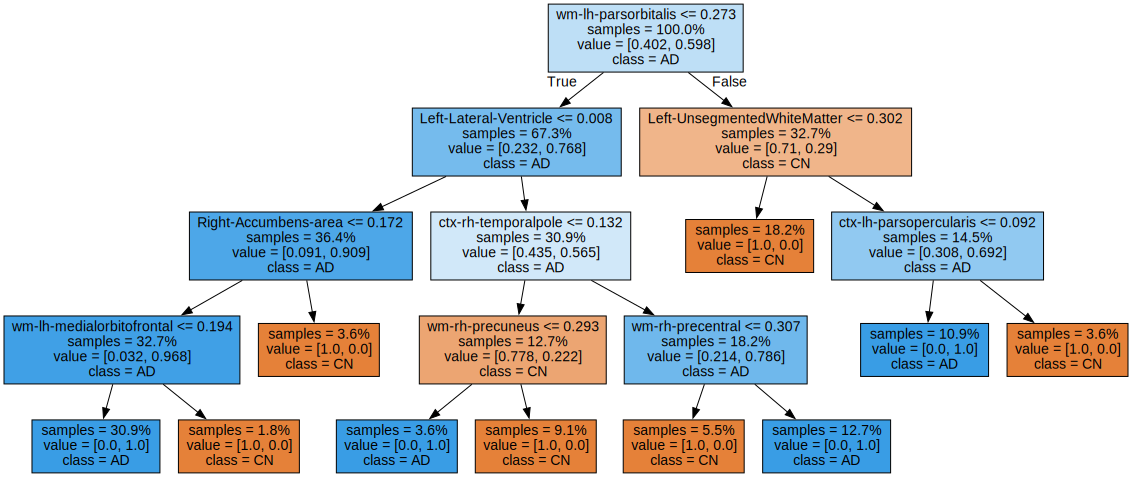

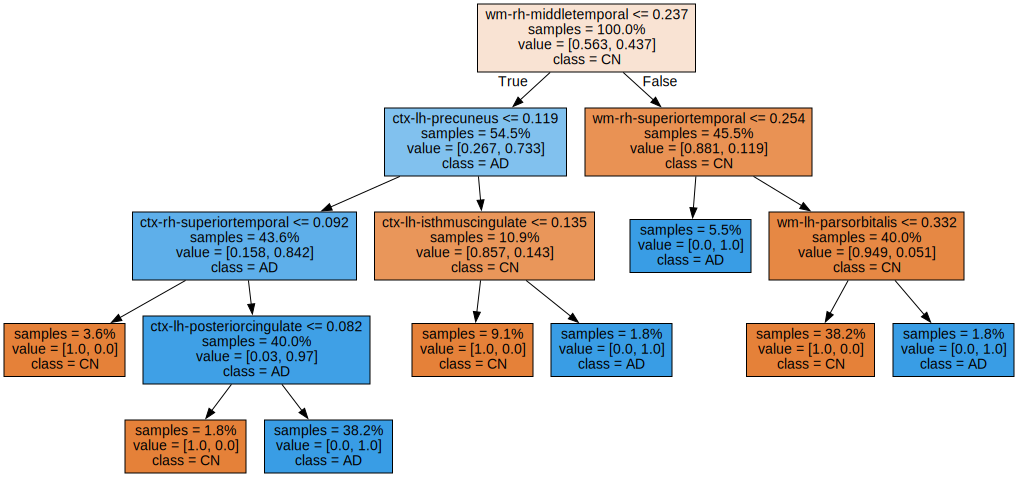

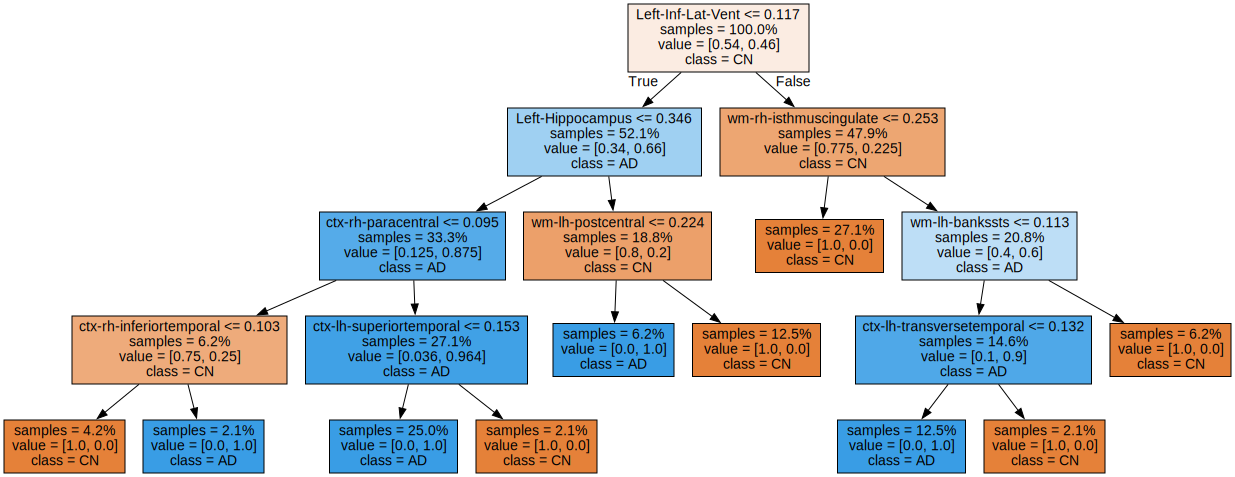

In [12]:
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

for i in range(3):
    tree = rand_search.best_estimator_[i]
    dot_data = export_graphviz(tree,feature_names=region[1:],  filled=True, impurity=False, proportion=True,class_names=["CN","AD"])
    graph = graphviz.Source(dot_data)
    display(graph)

ROC

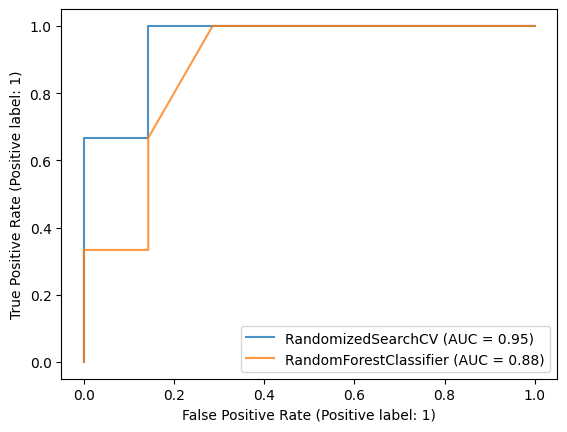

In [13]:
from sklearn.metrics import RocCurveDisplay
rf.fit(X_tr, y_tr)

ax = plt.gca()
rnds_disp = RocCurveDisplay.from_estimator(rand_search, X_tst, y_tst, ax=ax, alpha=0.8)
rndf_disp = RocCurveDisplay.from_estimator(rf, X_tst, y_tst, ax=ax, alpha=0.8)


plt.show()

Pipeline con solo Random Search per il tuning degli hyperparams

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

pipeline_simple = Pipeline(steps=[("hyper_opt", RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_dist, n_iter=50, cv=5))])
pipeline_simple.fit(X_tr, y_tr)

Pipeline(steps=[('hyper_opt',
                 RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                                    n_iter=50,
                                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC0C69A8C0>,
                                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC0C5026E0>}))])

In [15]:
y_pred = pipeline_simple.predict(X_tst)

accuracy = accuracy_score(y_tst, y_pred)
precision = precision_score(y_tst, y_pred)
recall = recall_score(y_tst, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9
Precision: 0.75
Recall: 1.0


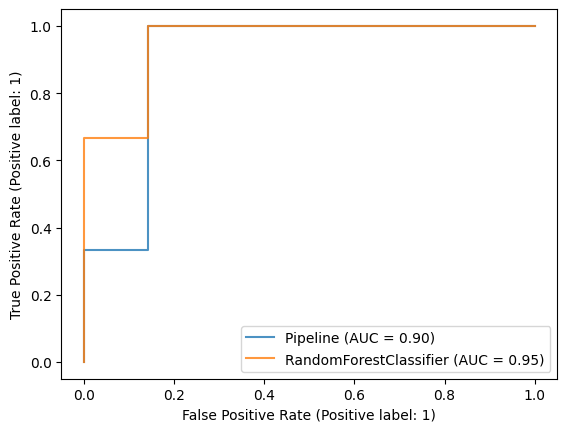

In [16]:
rf.fit(X_tr, y_tr)

ax = plt.gca()
rnds_disp = RocCurveDisplay.from_estimator(pipeline_simple, X_tst, y_tst, ax=ax, alpha=0.8)
rndf_disp = RocCurveDisplay.from_estimator(rf, X_tst, y_tst, ax=ax, alpha=0.8)


plt.show()

Pipeline con PCA e Random Search per dimensionality reduction e il tuning degli hyperparams 

In [17]:
pipeline_PCA = Pipeline(steps=[("dim_reduction", PCA()),
                               ("hyper_opt", RandomizedSearchCV(RandomForestClassifier(), param_distributions = param_dist, n_iter=50, cv=5))])
pipeline_PCA.fit(X_tr, y_tr)

Pipeline(steps=[('dim_reduction', PCA()),
                ('hyper_opt',
                 RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                                    n_iter=50,
                                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC0C69A8C0>,
                                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BC0C5026E0>}))])

In [18]:
y_pred = pipeline_PCA.predict(X_tst)

accuracy = accuracy_score(y_tst, y_pred)
precision = precision_score(y_tst, y_pred)
recall = recall_score(y_tst, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9
Precision: 0.75
Recall: 1.0


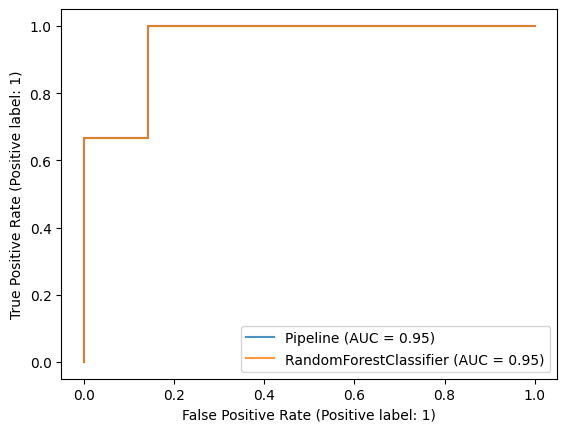

In [19]:
ax = plt.gca()
rnds_disp = RocCurveDisplay.from_estimator(pipeline_PCA, X_tst, y_tst, ax=ax, alpha=0.8)
rndf_disp = RocCurveDisplay.from_estimator(rf, X_tst, y_tst, ax=ax, alpha=0.8)


plt.show()